Nested sampling analysis of dark dresses at terrestrial detectors. I recommend checking out the [dynesty docs](https://dynesty.readthedocs.io/en/latest/crashcourse.html).

The analysis below requires defining `ptform` (a function mapping numbers from the unit hypercube `[0, 1]^n` to a point `x` in the parameter space to define the prior), `unpack` (a function taking `x` and parsing it into a dark dress) and a likelihood function.

In [240]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
import pickle
from typing import Iterable, Optional, Tuple, Union

import dynesty
from dynesty import plotting as dyplot
import jax.numpy as jnp
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np

from pydd.binary import MSUN, DAY, YR, PC
from pydd.noise import S_n_et as S_n, f_range_et as f_range_n
from pydd.utils import get_target_pbh_dynamicdress
from dynesty.plotting import _hist2d
from scipy.ndimage import gaussian_filter as norm_kde

## Setup

In [286]:
plt.style.use("../plot_style.mplstyle")
LEVELS = (0.68268, 0.95450, 0.99730)
# LEVELS = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
TRUTH_KWARGS = dict(color="k", linewidth=0.75, linestyle="--")
T_OBS = 1 * DAY
SNR_THRESH = 12
DD_D, F_RANGE_D = get_target_pbh_dynamicdress(
    1 * MSUN, 1e-3 * MSUN, T_OBS, SNR_THRESH, S_n, f_range_n
)


def get_HDI_thresholds(x, cred_level=LEVELS):
    """
    Taken from swyft.plot.plot
    """
    x = x.flatten()
    x = np.sort(x)[::-1]  # Sort backwards
    total_mass = x.sum()
    enclosed_mass = np.cumsum(x)
    idx = [np.argmax(enclosed_mass >= total_mass * f) for f in cred_level]
    levels = np.array(x[idx])
    return levels


def my_corner(
    results,
    axes,
    truths,
    color="grey",
    truth_kwargs: dict = TRUTH_KWARGS,
    bins_1d: Union[float, list[float]] = 50,
    smooth: Union[float, list[float]] = 0.015,
    levels: list[float] = LEVELS,
    offsets: np.ndarray = np.zeros(4),
    contour_kwargs: Optional[dict] = None,
    contourf_kwargs: Optional[dict] = None,
    no_fill_contours: Optional[bool] = False,
):
    span = [0.999999426697 for i in range(2)]

    samples = (results["samples"] - offsets).T
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])
    if type(bins_1d) == float:
        bins_1d = (bins_1d for _ in range(len(samples)))

    for i, x in enumerate(samples):
        ax = axes[i, i]
        ax.hist(
            x,
            weights=weights,
            bins=bins_1d[i],
            density=True,
            histtype="step",
            color=color,
        )
        ax.axvline(truths[i], **truth_kwargs)

        for j, y in enumerate(samples):
            ax = axes[i, j]
            if j == i:
                continue
            if j > i:
                ax.axis("off")
                continue
            _hist2d(
                y,
                x,
                weights=weights,
                ax=ax,
                color=color,
                smooth=smooth,
                levels=levels,
                contour_kwargs=contour_kwargs,
                contourf_kwargs=contourf_kwargs,
                no_fill_contours=no_fill_contours,
                plot_density=False,
            )
            ax.axvline(truths[j], **truth_kwargs)
            ax.axhline(truths[i], **truth_kwargs)

## Load and plot results

In [298]:
labels = (
    r"$\gamma_s$",
    r"$\rho_6$ [$10^{16}$ M$_\odot$/pc$^3$]",
    r"$\Delta\mathcal{M}$ [M$_\odot$]",
    r"$\log_{10} q$",
)
quantiles_2d = [0.6827, 0.9545, 0.9973]  # more typical for Bayesian analyses
truths = (
    DD_D.gamma_s,
    DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
    0,  # DD_D.M_chirp / MSUN,
    jnp.log10(DD_D.q),
)

with open(f"../scripts/ns/ns-et-1day-test-4d.pkl", "rb") as infile:
    results_et_1day = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1week-test-4d.pkl", "rb") as infile:
    results_et_1week = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1month-test-4d.pkl", "rb") as infile:
    results_et_1month = pickle.load(infile)

with open(f"../scripts/ns/ns-et-1yr-test-4d.pkl", "rb") as infile:
    results_et_1yr = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1day-test-4d.pkl", "rb") as infile:
    results_ce_1day = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1week-test-4d.pkl", "rb") as infile:
    results_ce_1week = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1month-test-4d.pkl", "rb") as infile:
    results_ce_1month = pickle.load(infile)

with open(f"../scripts/ns/ns-ce-1yr-test-4d.pkl", "rb") as infile:
    results_ce_1yr = pickle.load(infile)

### CE

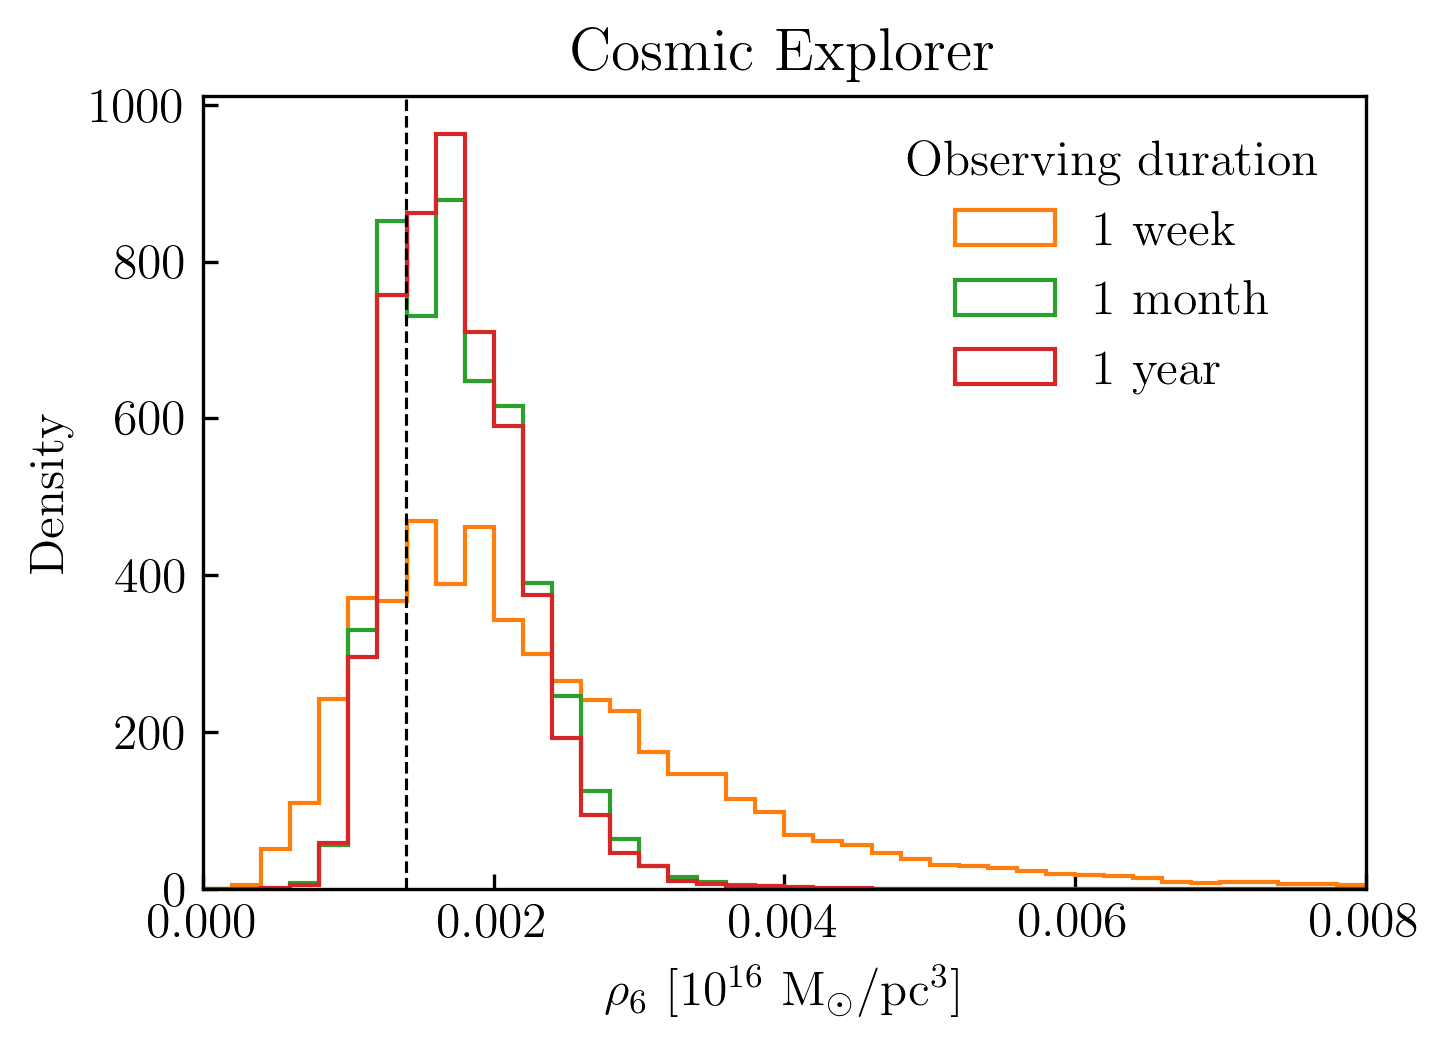

In [300]:
bins = np.linspace(0, 0.008, 41)
for i, (results, t_obs_label) in enumerate(
    zip(
        [results_ce_1week, results_ce_1month, results_ce_1yr],
        ["1 week", "1 month", "1 year"],
    ),
    start=1,
):
    samples = (results["samples"] - offsets).T[1]
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])
    plt.hist(
        samples,
        bins,
        weights=weights,
        density=True,
        color=f"C{i}",
        histtype="step",
        label=t_obs_label,
    )

plt.axvline(DD_D.rho_6 / (1e16 * MSUN / PC ** 3), **TRUTH_KWARGS)
plt.xlim(bins[[0, -1]])
plt.xlabel(labels[1])
plt.ylabel("Density")
plt.legend(title="Observing duration")
plt.title("Cosmic Explorer")
plt.savefig("figures/post-rho6-ce-week-month-year.pdf")

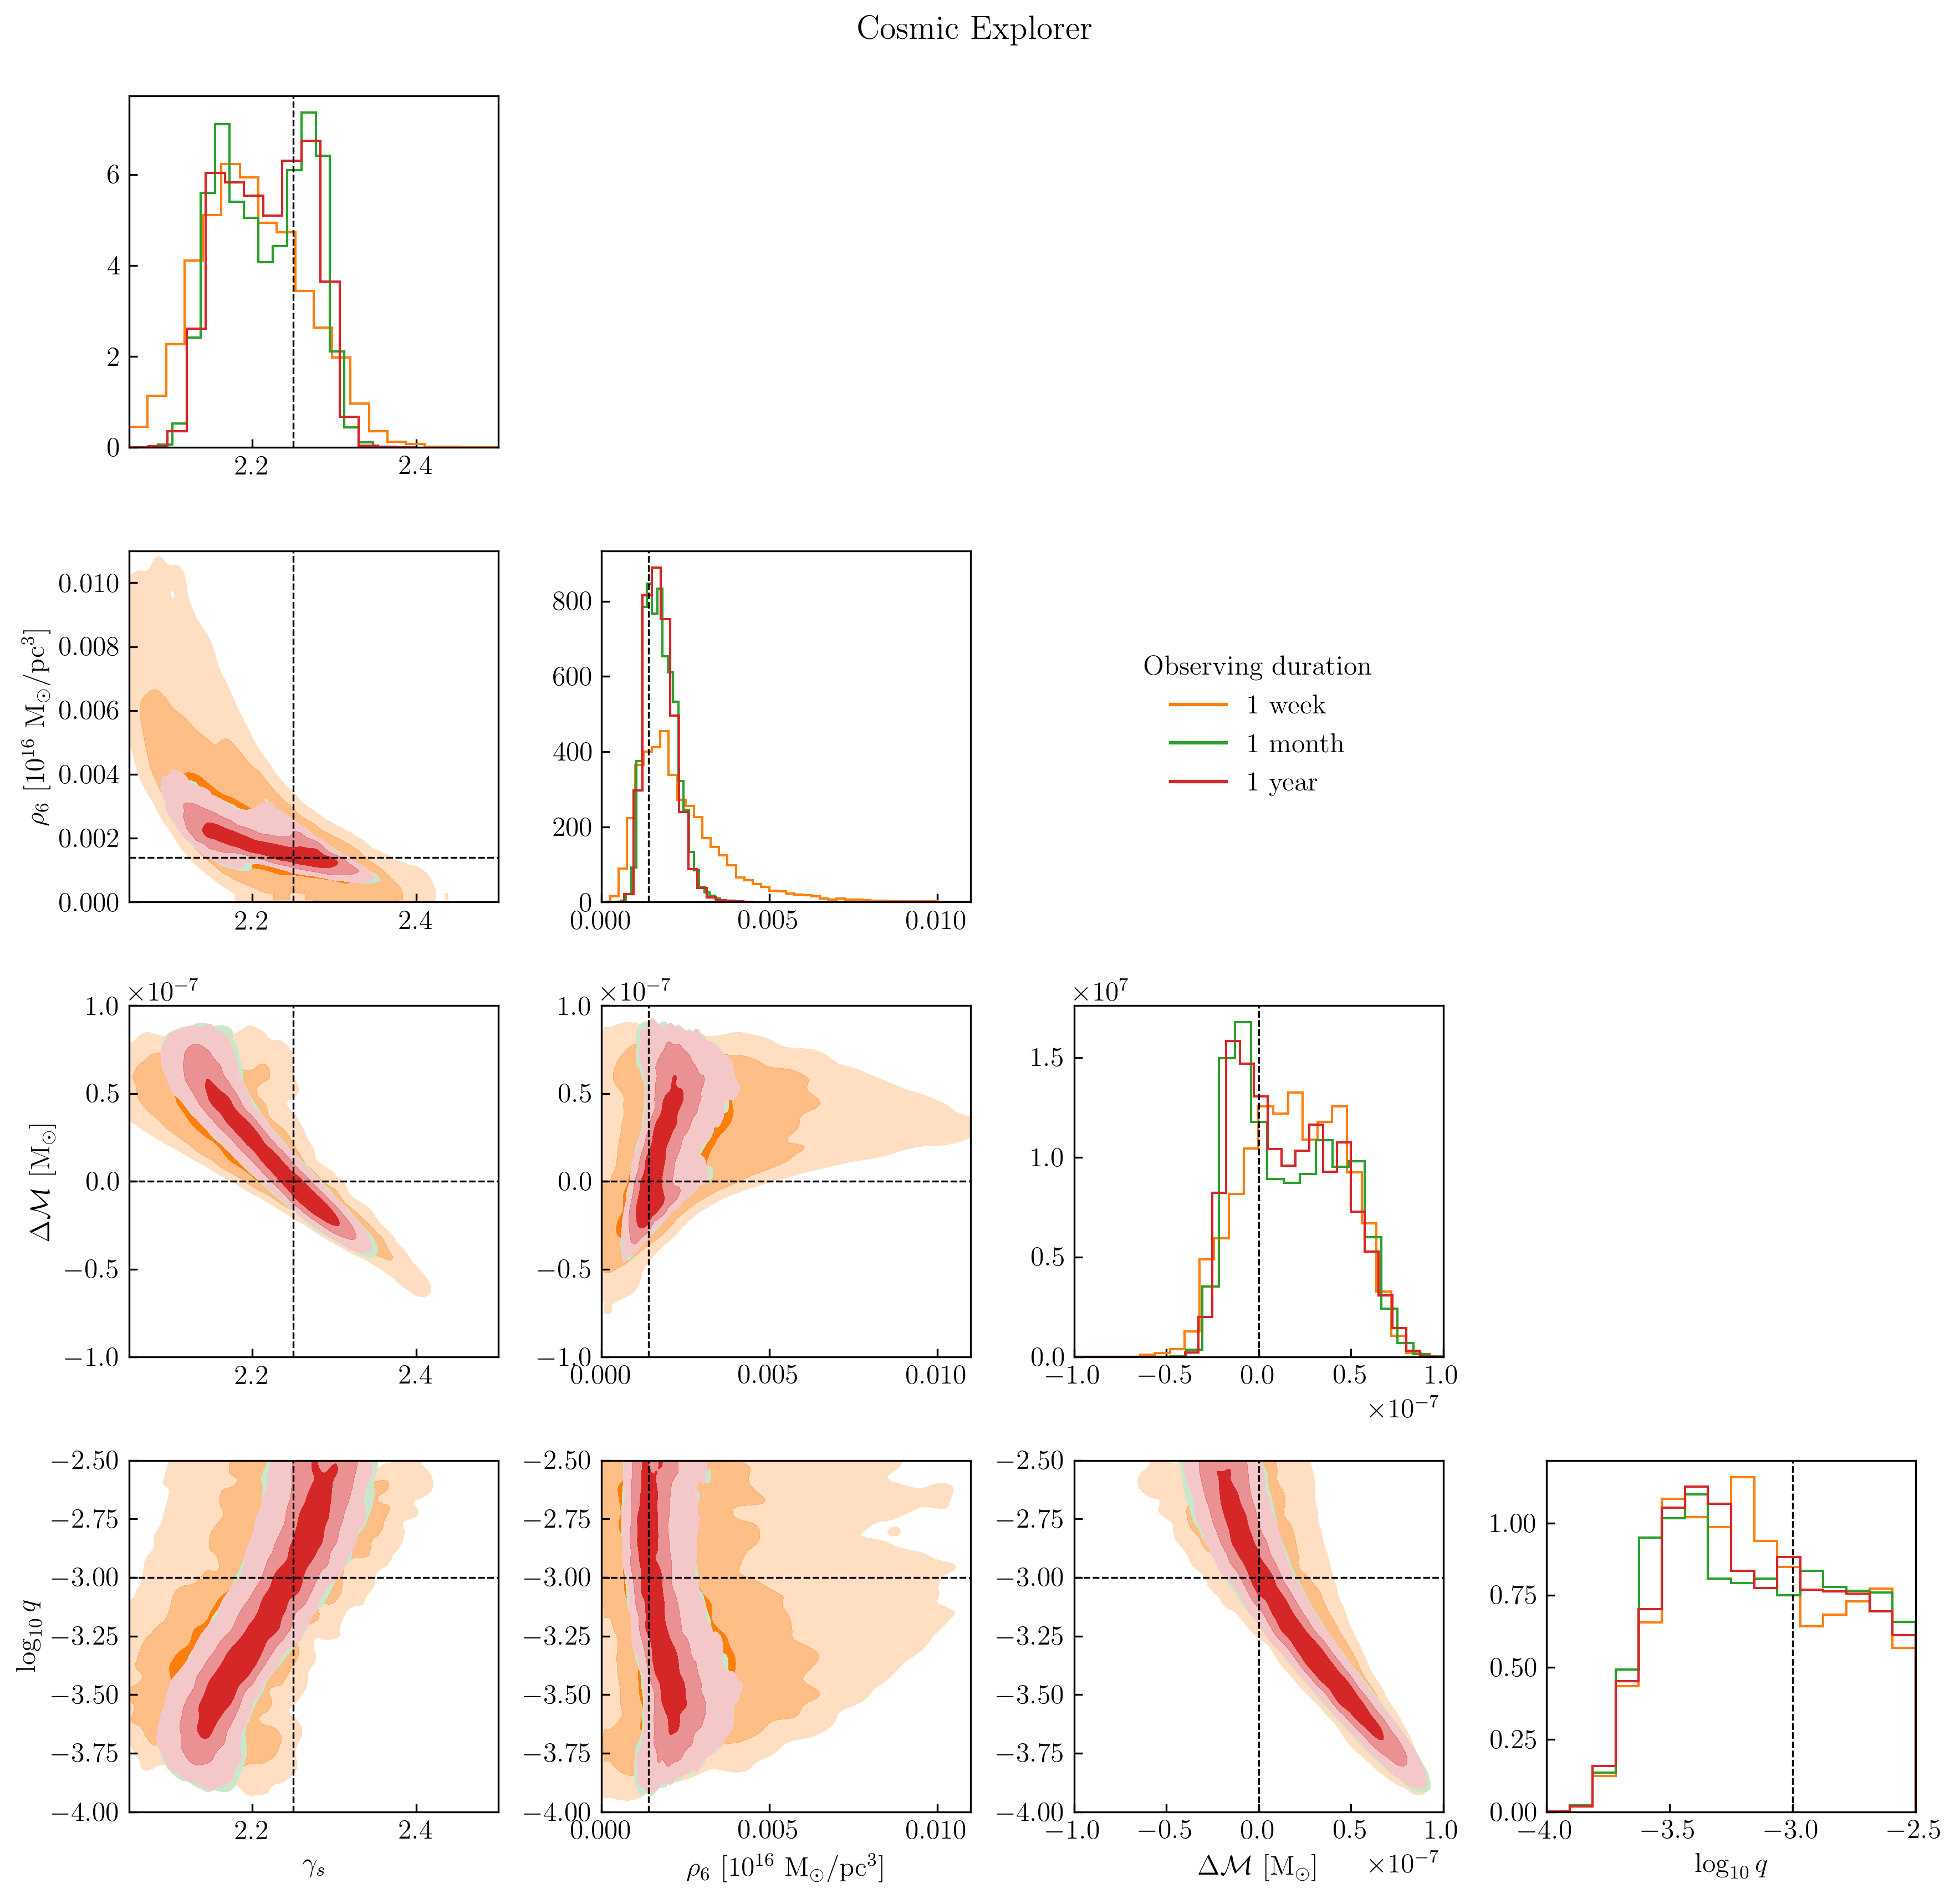

In [302]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

my_corner(
    results_ce_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(20, 80, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(20, 25, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_ce_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(15, 15, 40, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (2.05, 2.5),
    (0.0, 0.011),
    (-1e-7, 1e-7),
    (-4, -2.5),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

ax = axes[1, 2]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 week", "1 month", "1 year"], 1):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Cosmic Explorer")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("figures/post-ce-week-month-year.pdf")

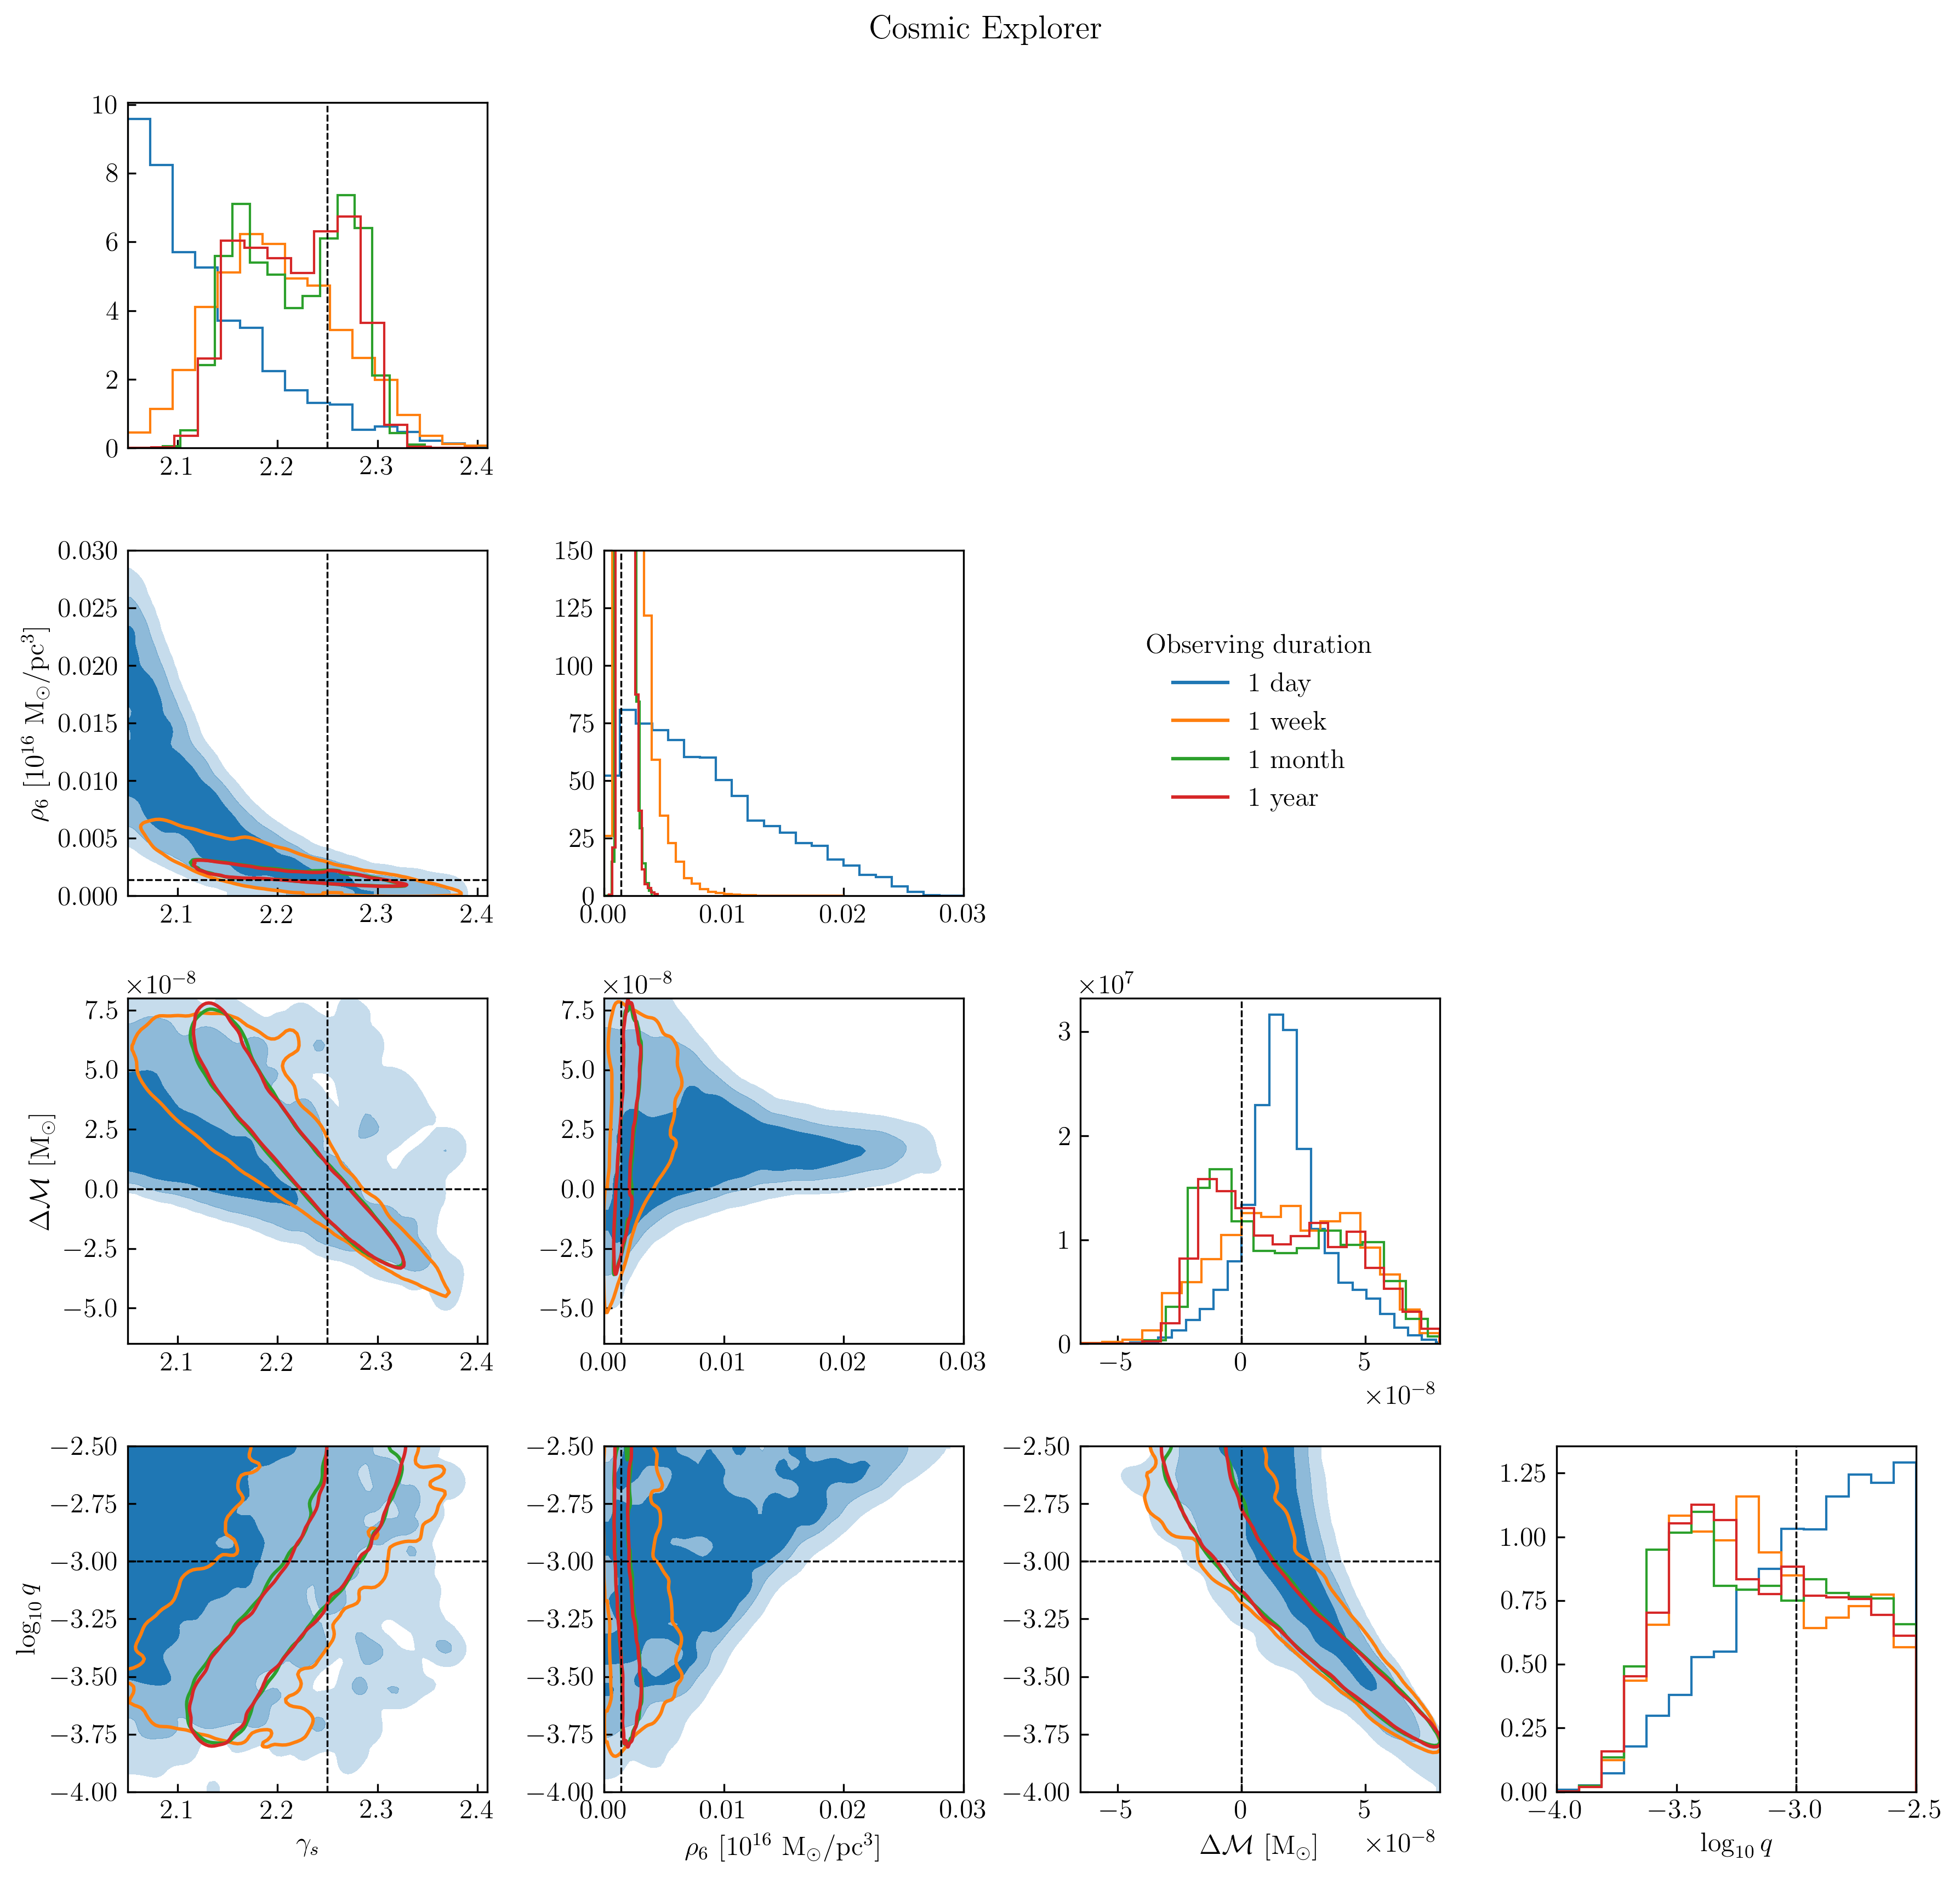

In [303]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

my_corner(
    results_ce_1day,
    axes,
    truths,
    "C0",
    smooth=0.025,
    bins_1d=(20, 30, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0)
)
my_corner(
    results_ce_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(20, 30, 250, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)
my_corner(
    results_ce_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(20, 15, 250, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)
my_corner(
    results_ce_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(15, 15, 40, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (2.05, 2.41),
    (0.0, 0.03),
    (-6.5e-8, 8e-8),
    (-4, -2.5),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

axes[1, 1].set_ylim(0, 150)

ax = axes[1, 2]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 day", "1 week", "1 month", "1 year"]):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Cosmic Explorer")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("figures/post-ce-all.pdf")

### ET

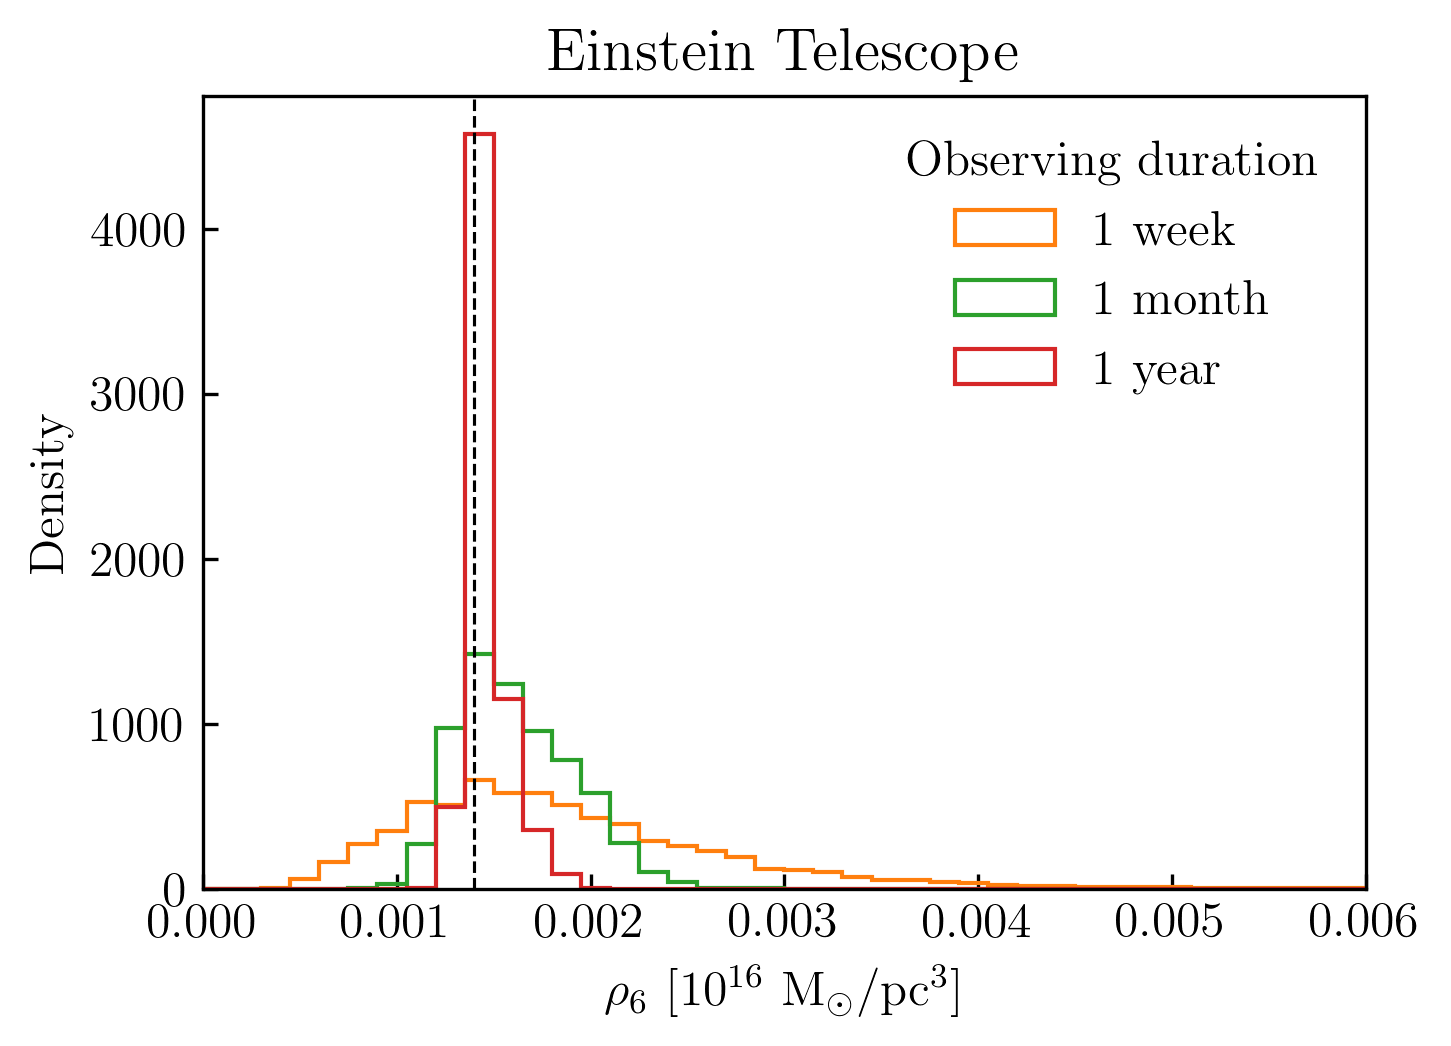

In [297]:
bins = np.linspace(0, 0.006, 41)
for i, (results, t_obs_label) in enumerate(
    zip(
        [results_et_1week, results_et_1month, results_et_1yr],
        ["1 week", "1 month", "1 year"],
    ),
    start=1,
):
    samples = (results["samples"] - offsets).T[1]
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])
    plt.hist(
        samples,
        bins,
        weights=weights,
        density=True,
        color=f"C{i}",
        histtype="step",
        label=t_obs_label,
    )

plt.axvline(DD_D.rho_6 / (1e16 * MSUN / PC ** 3), **TRUTH_KWARGS)
plt.xlim(bins[[0, -1]])
plt.xlabel(labels[1])
plt.ylabel("Density")
plt.legend(title="Observing duration")
plt.title("Einstein Telescope")
plt.savefig("figures/post-rho6-et-week-month-year.pdf")

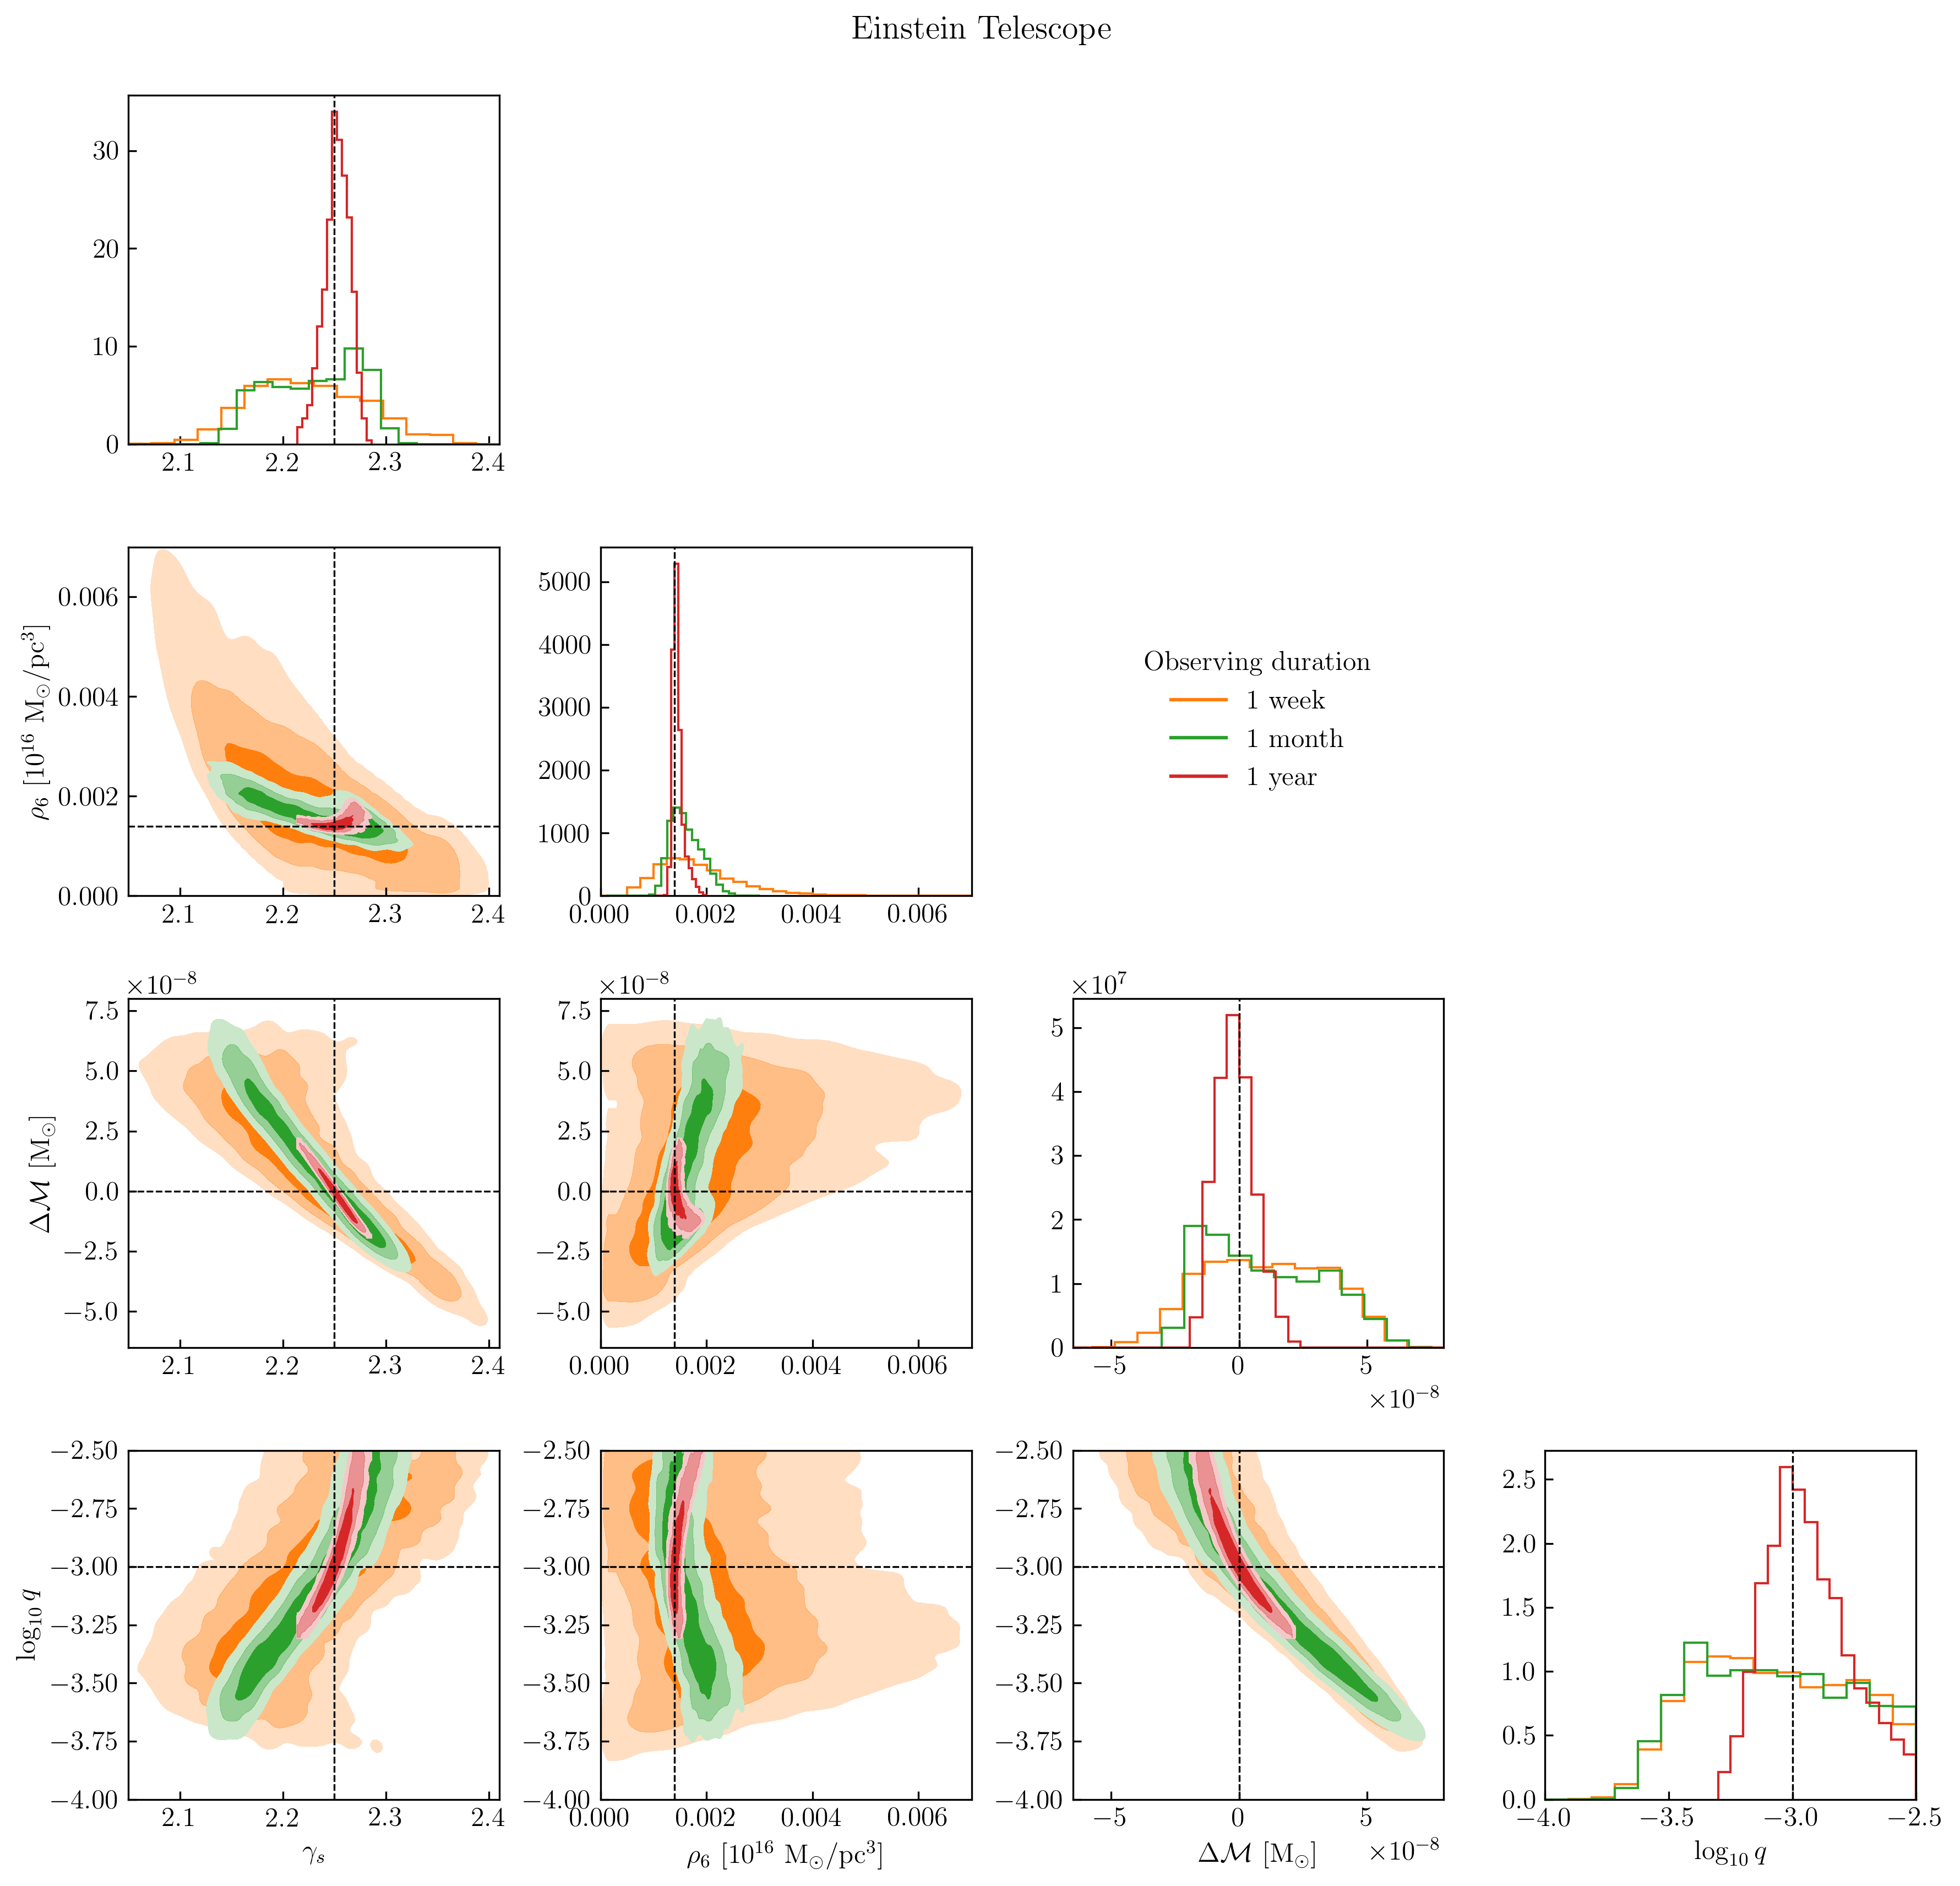

In [282]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

my_corner(
    results_et_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(20, 80, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(20, 25, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)
my_corner(
    results_et_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(15, 15, 40, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0),
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (2.05, 2.41),
    (0.0, 0.007),
    (-6.5e-8, 8e-8),
    (-4, -2.5),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

ax = axes[1, 2]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 week", "1 month", "1 year"], 1):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Einstein Telescope")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("figures/post-et-week-month-year.pdf")

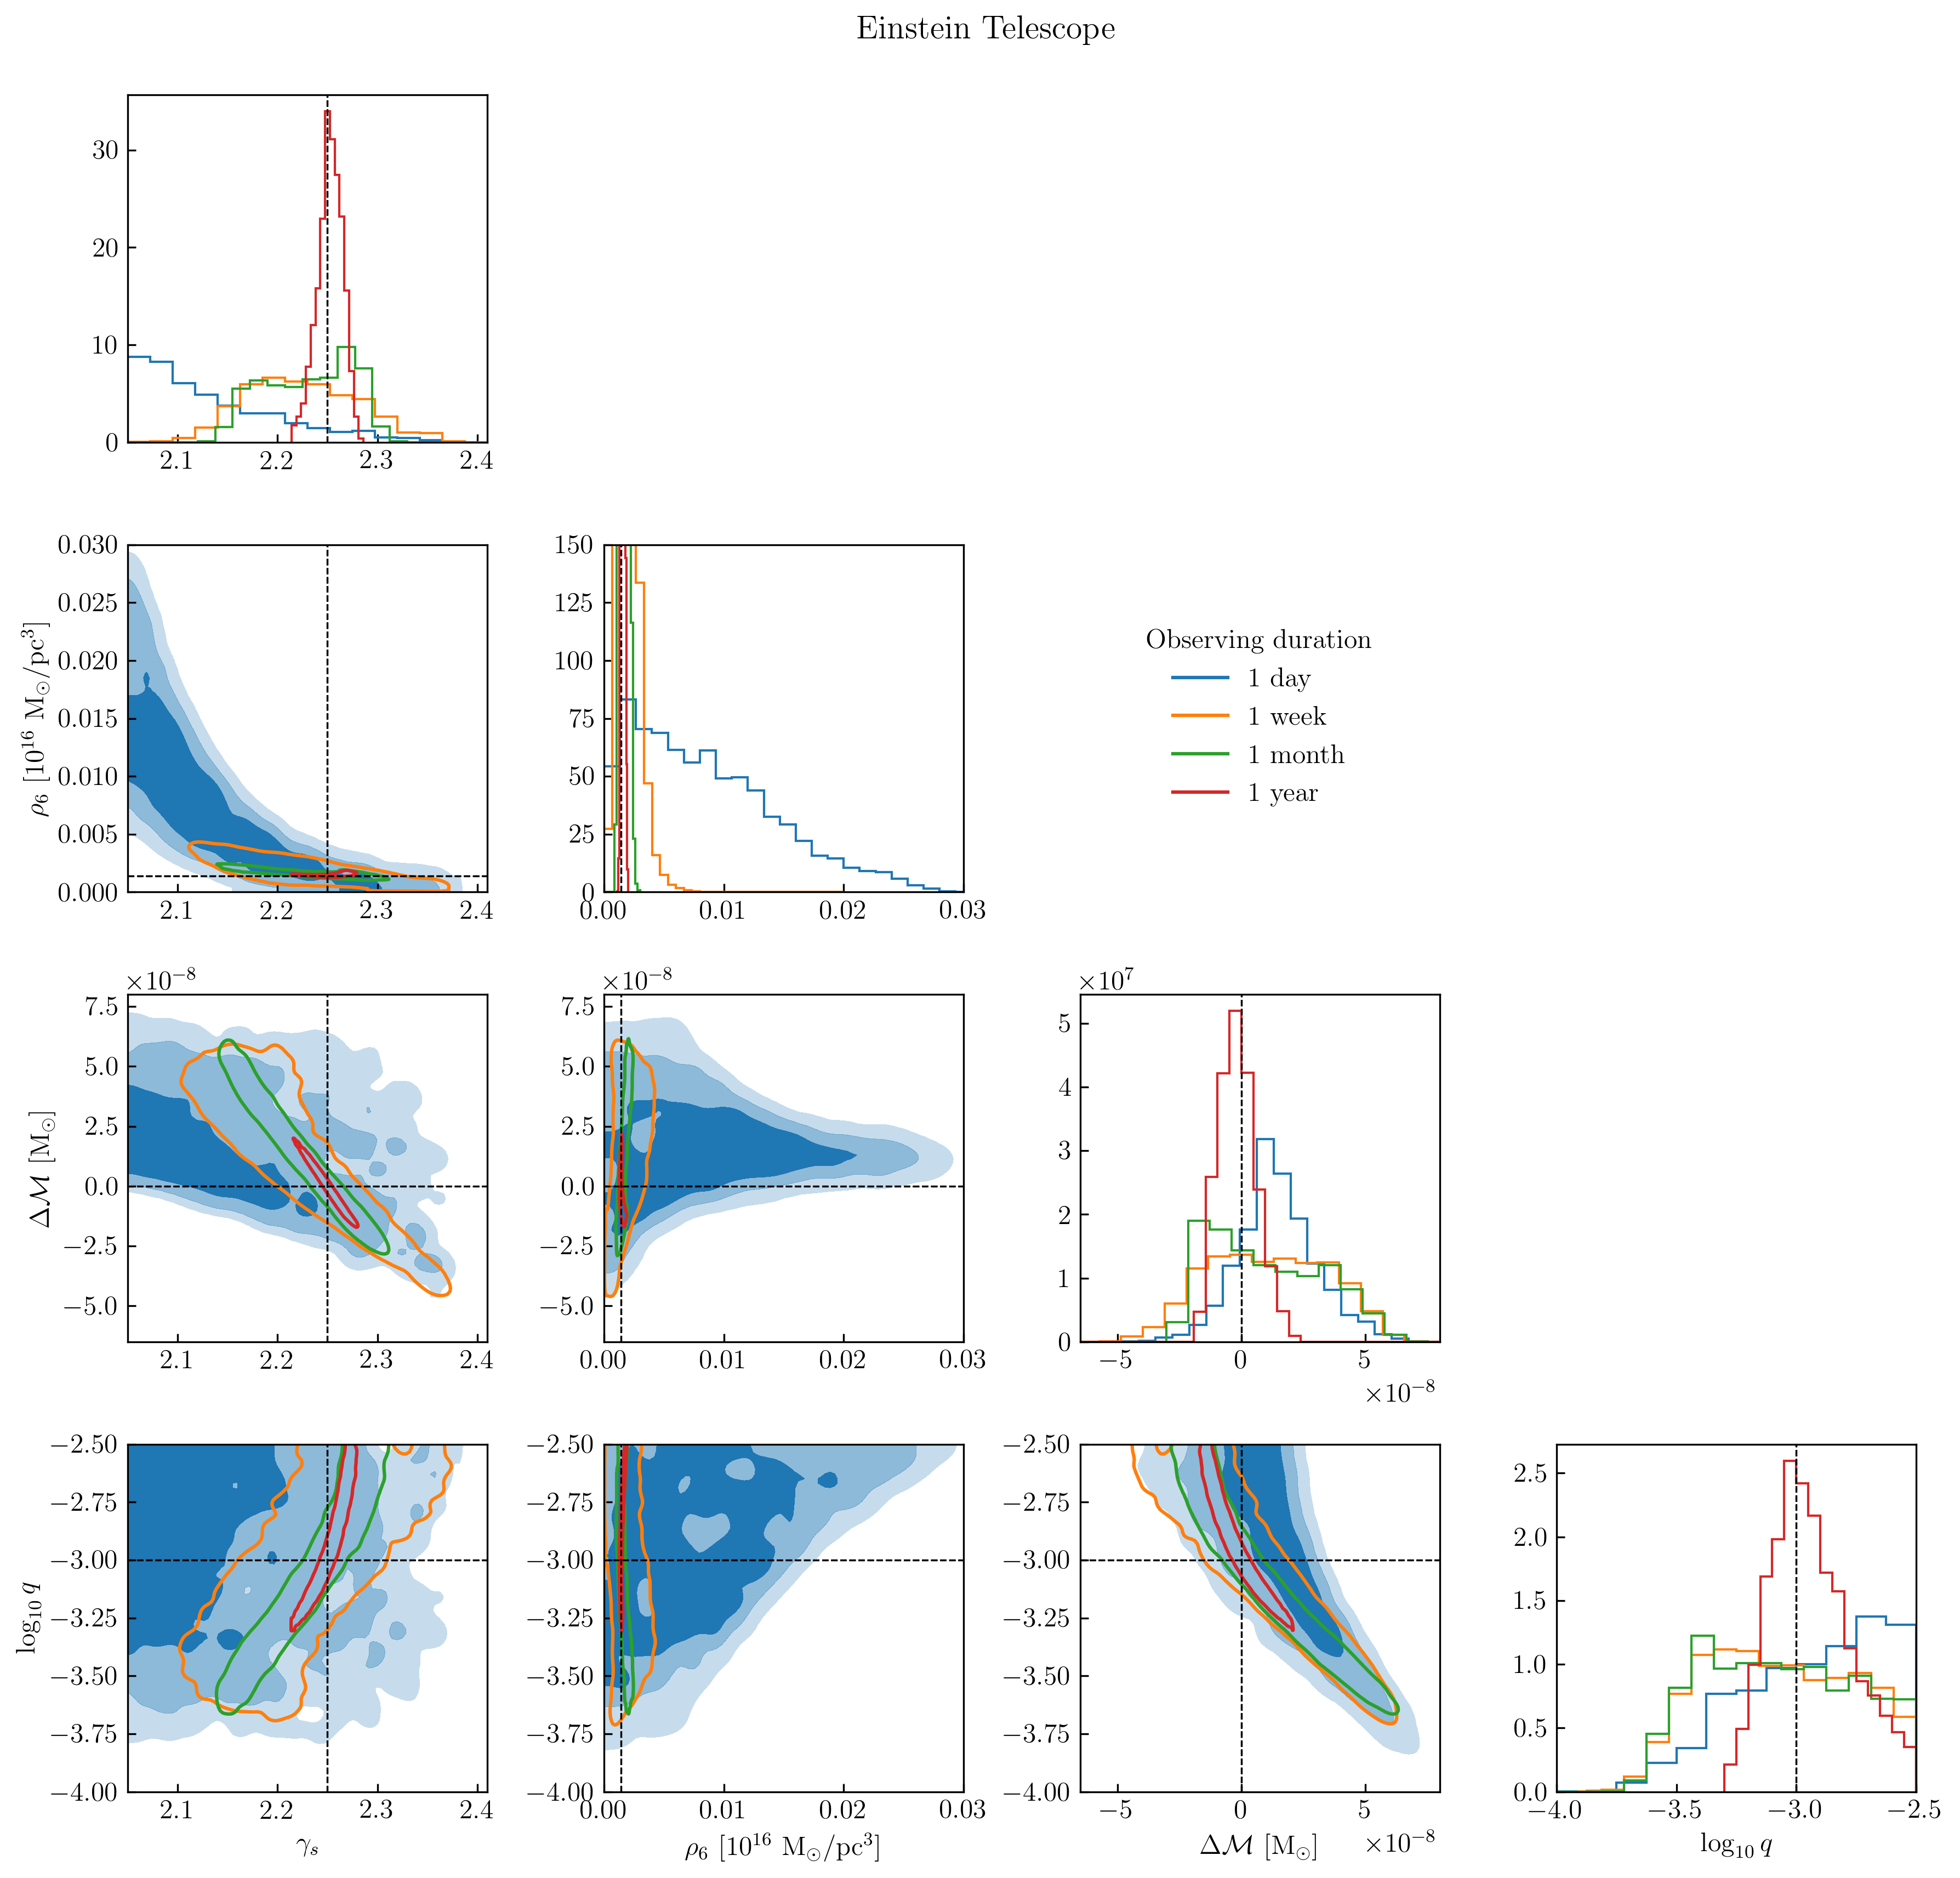

In [283]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

offsets = (0, 0, DD_D.M_chirp / MSUN, 0)

my_corner(
    results_et_1day,
    axes,
    truths,
    "C0",
    smooth=0.025,
    bins_1d=(20, 30, 250, 16),
    offsets=offsets,
    contour_kwargs=dict(linewidths=0)
)
my_corner(
    results_et_1week,
    axes,
    truths,
    "C1",
    smooth=0.018,
    bins_1d=(20, 30, 250, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)
my_corner(
    results_et_1month,
    axes,
    truths,
    "C2",
    smooth=0.018,
    bins_1d=(20, 15, 250, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)
my_corner(
    results_et_1yr,
    axes,
    truths,
    "C3",
    smooth=0.018,
    bins_1d=(15, 15, 40, 16),
    offsets=offsets,
    levels=(0, LEVELS[1]),
    no_fill_contours=True,
    contourf_kwargs=dict(alpha=0)
)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

# Week/month/year
ranges = [
    (2.05, 2.41),
    (0.0, 0.03),
    (-6.5e-8, 8e-8),
    (-4, -2.5),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

axes[1, 1].set_ylim(0, 150)

ax = axes[1, 2]
handles = ax.get_legend_handles_labels()[0]
for i, t_obs_label in enumerate(["1 day", "1 week", "1 month", "1 year"]):
    line = Line2D([0], [0], label=t_obs_label, color=f"C{i}")
    handles.extend([line])
ax.legend(handles=handles, title="Observing duration", loc="center")

fig.suptitle("Einstein Telescope")
fig.tight_layout(rect=[0, 0.03, 1, 0.985])
fig.savefig("figures/post-et-all.pdf")

## Old

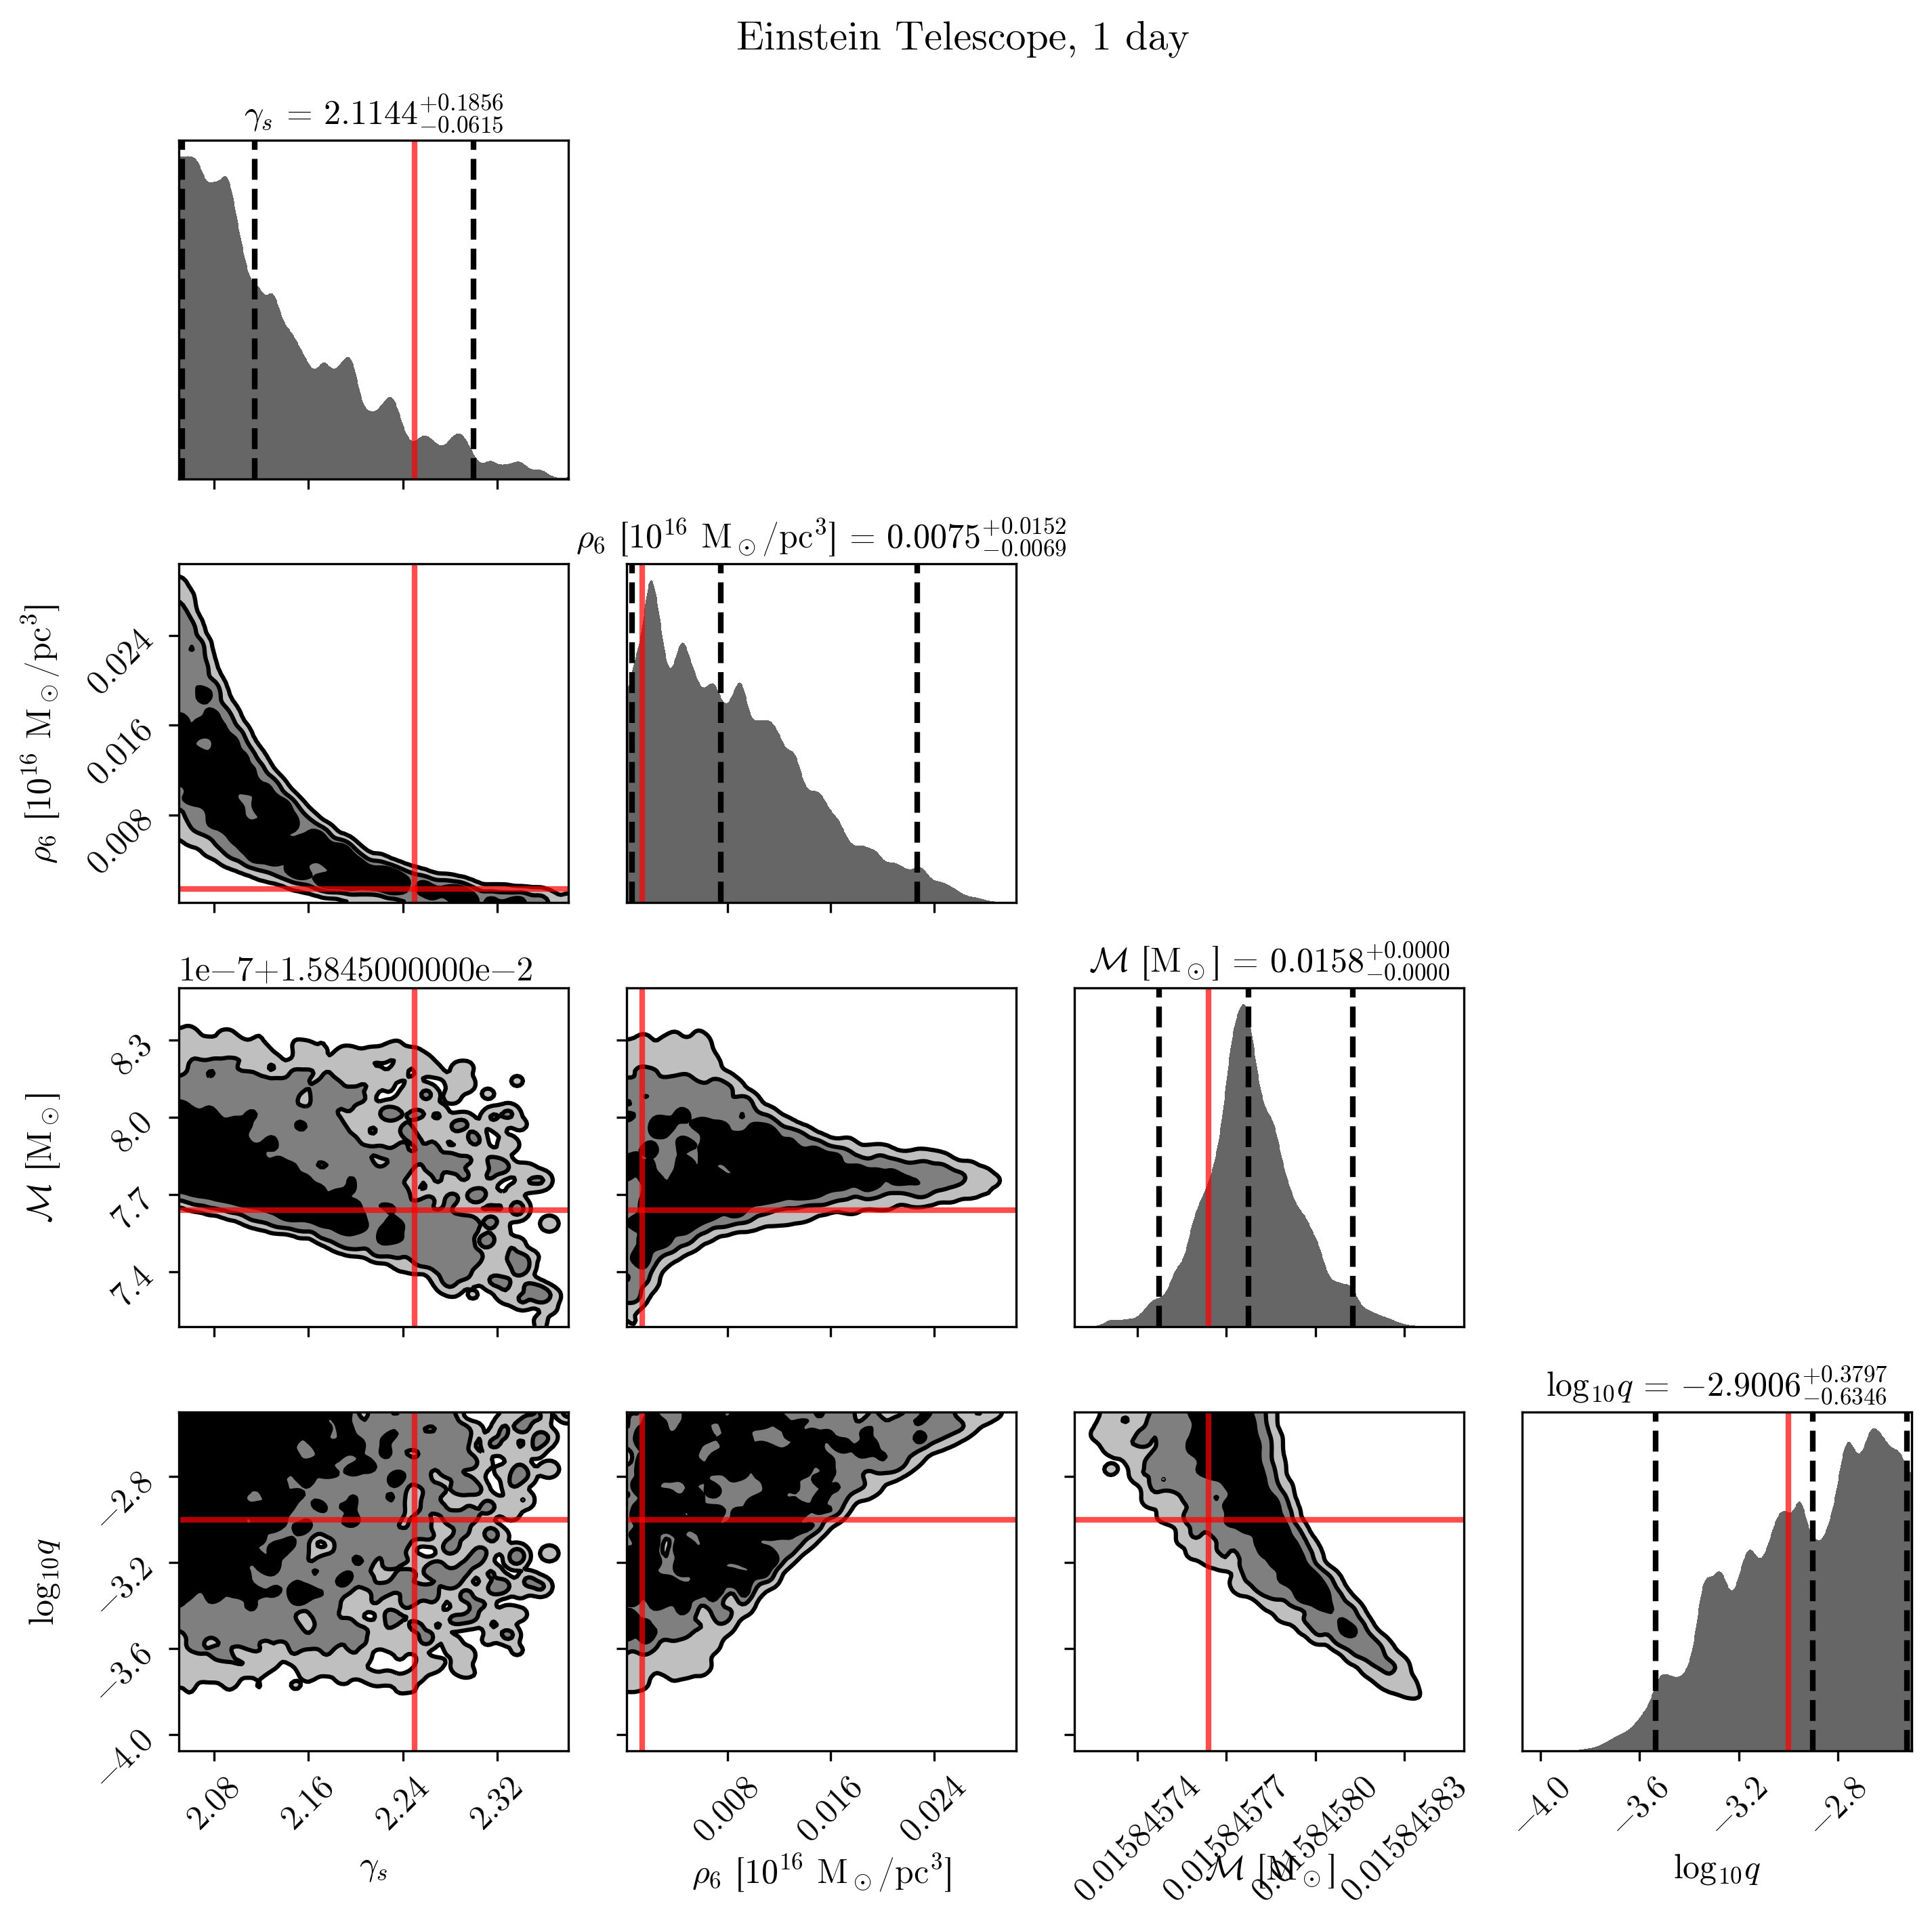

In [79]:
fig, axes = dyplot.cornerplot(
    results_et_1day,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle("Einstein Telescope, 1 day")
fig.tight_layout()
# fig.savefig(f"figures/ns-ce.pdf")

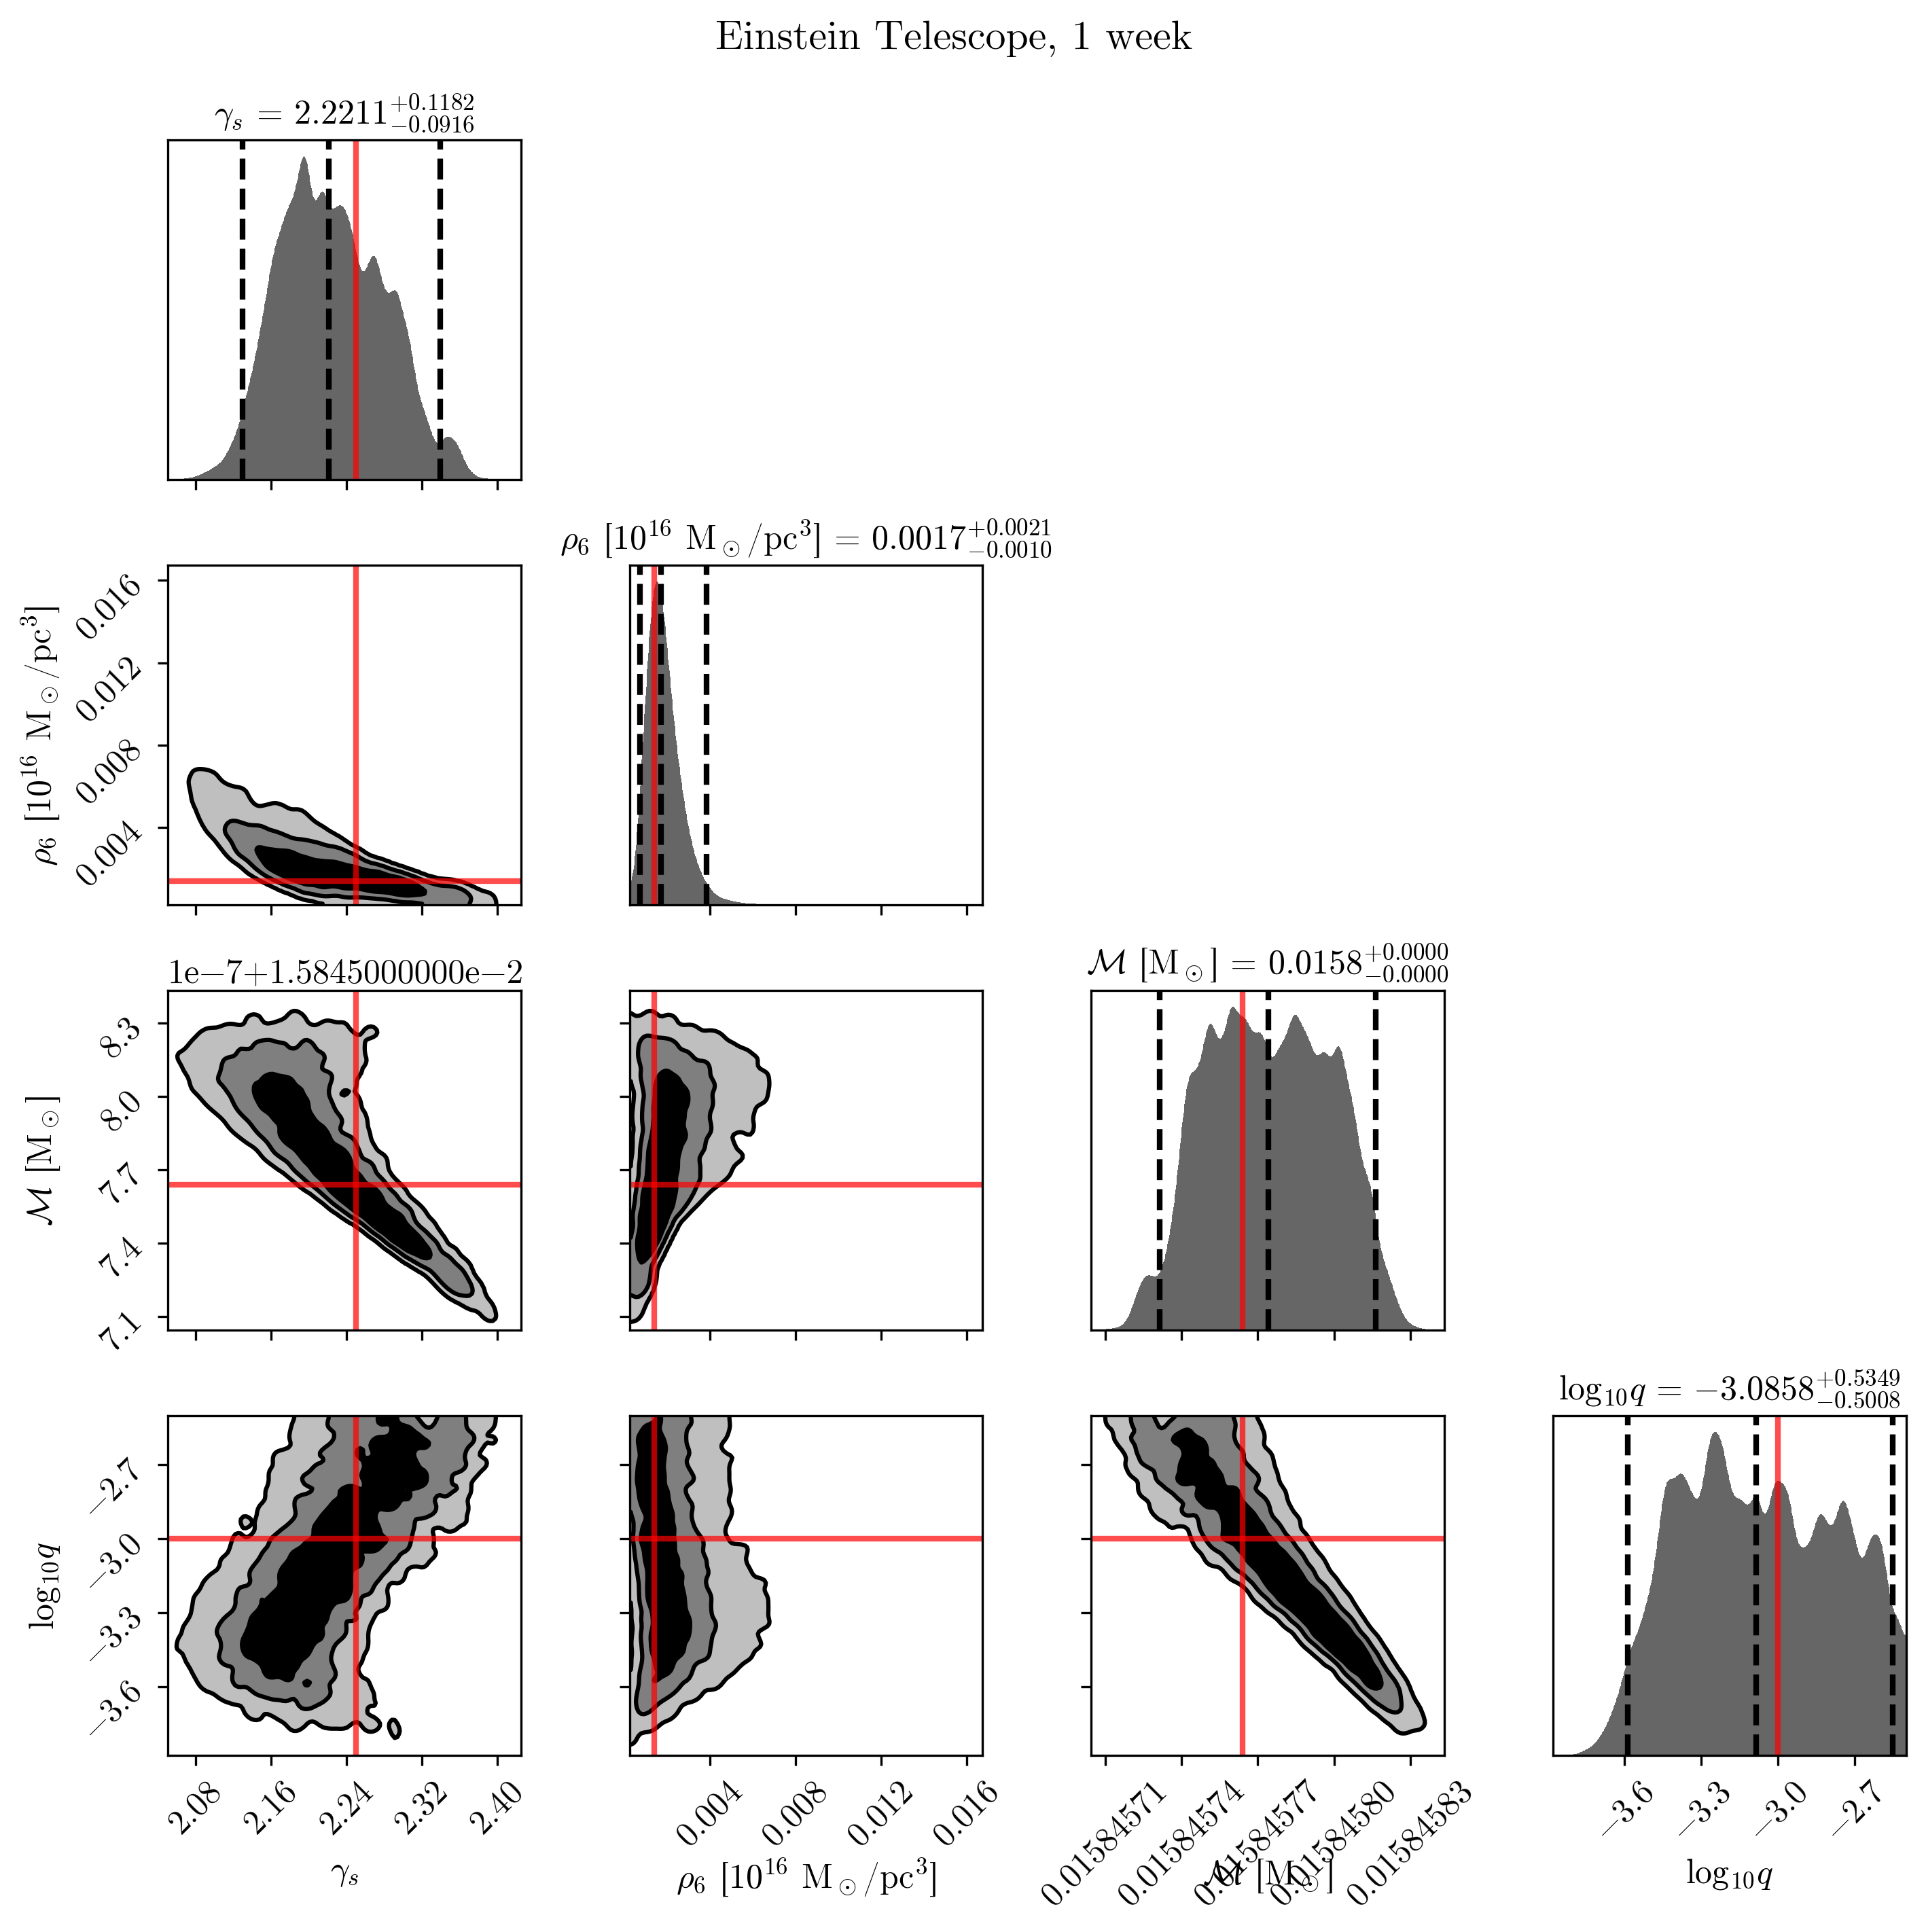

In [87]:
fig, axes = dyplot.cornerplot(
    results_et_1week,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle("Einstein Telescope, 1 week")
fig.tight_layout()
# fig.savefig(f"figures/ns-ce.pdf")

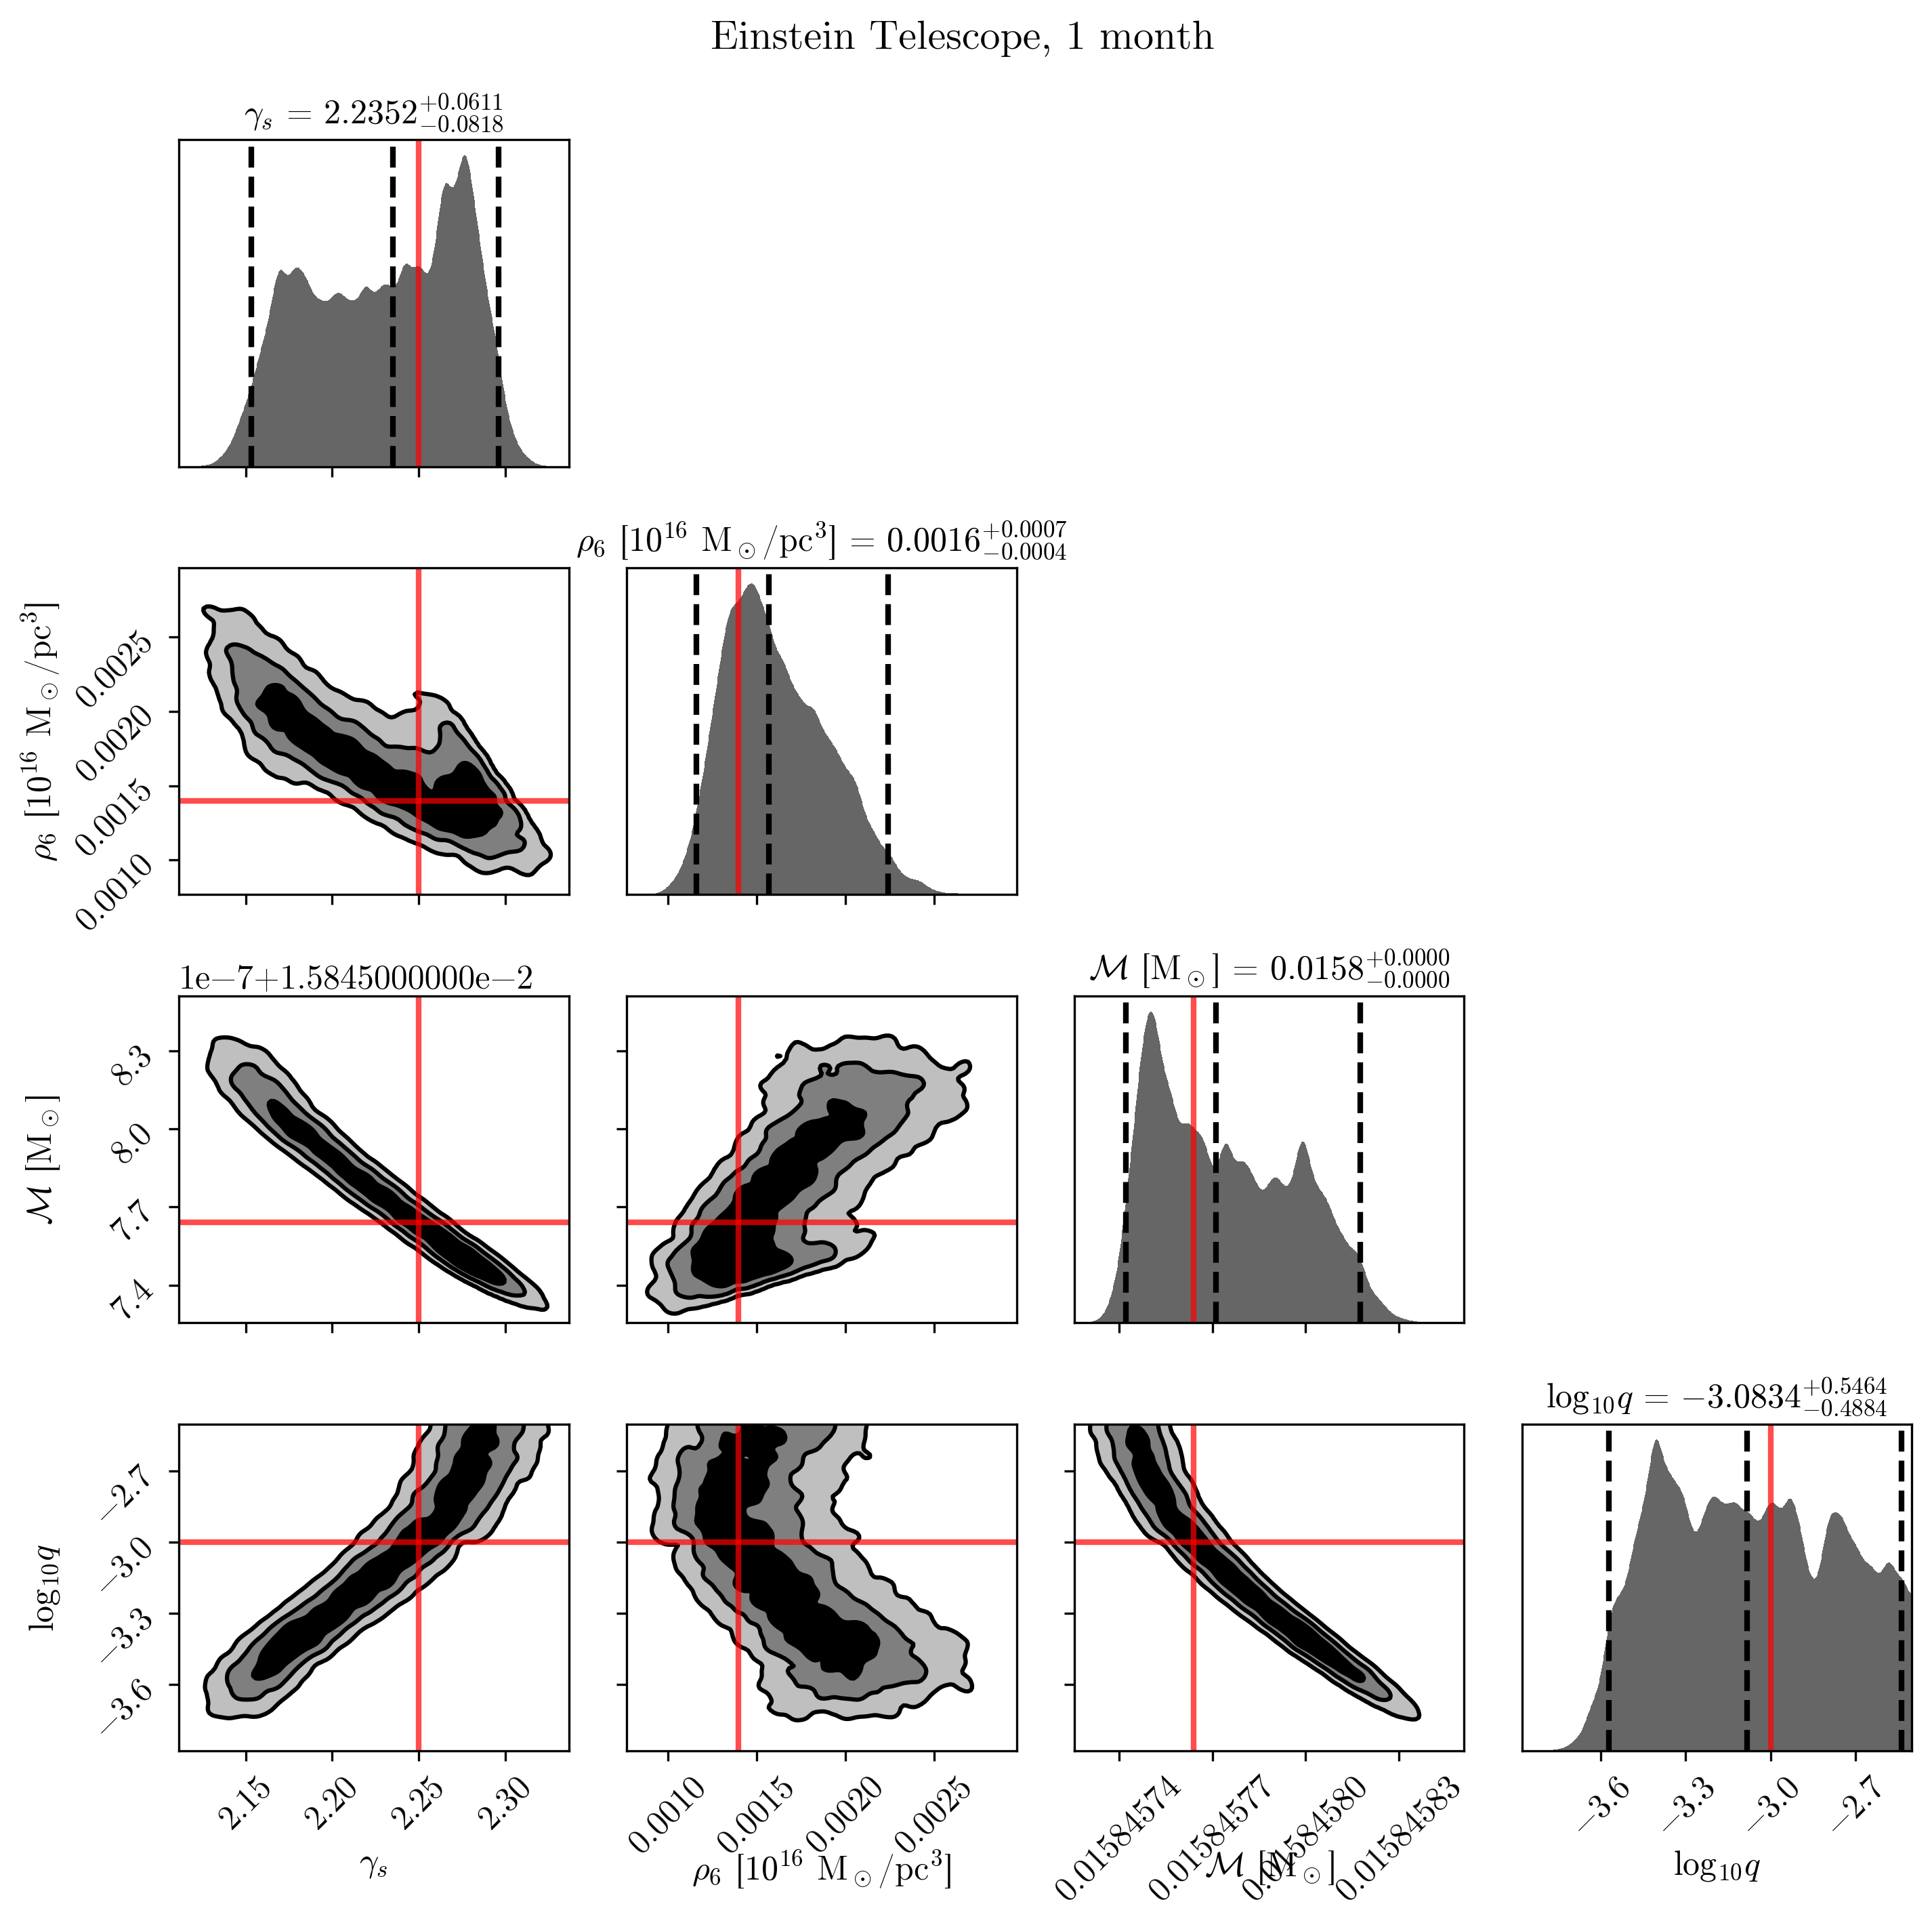

In [84]:
fig, axes = dyplot.cornerplot(
    results_et_1month,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle("Einstein Telescope, 1 month")
fig.tight_layout()
# fig.savefig(f"figures/ns-ce.pdf")

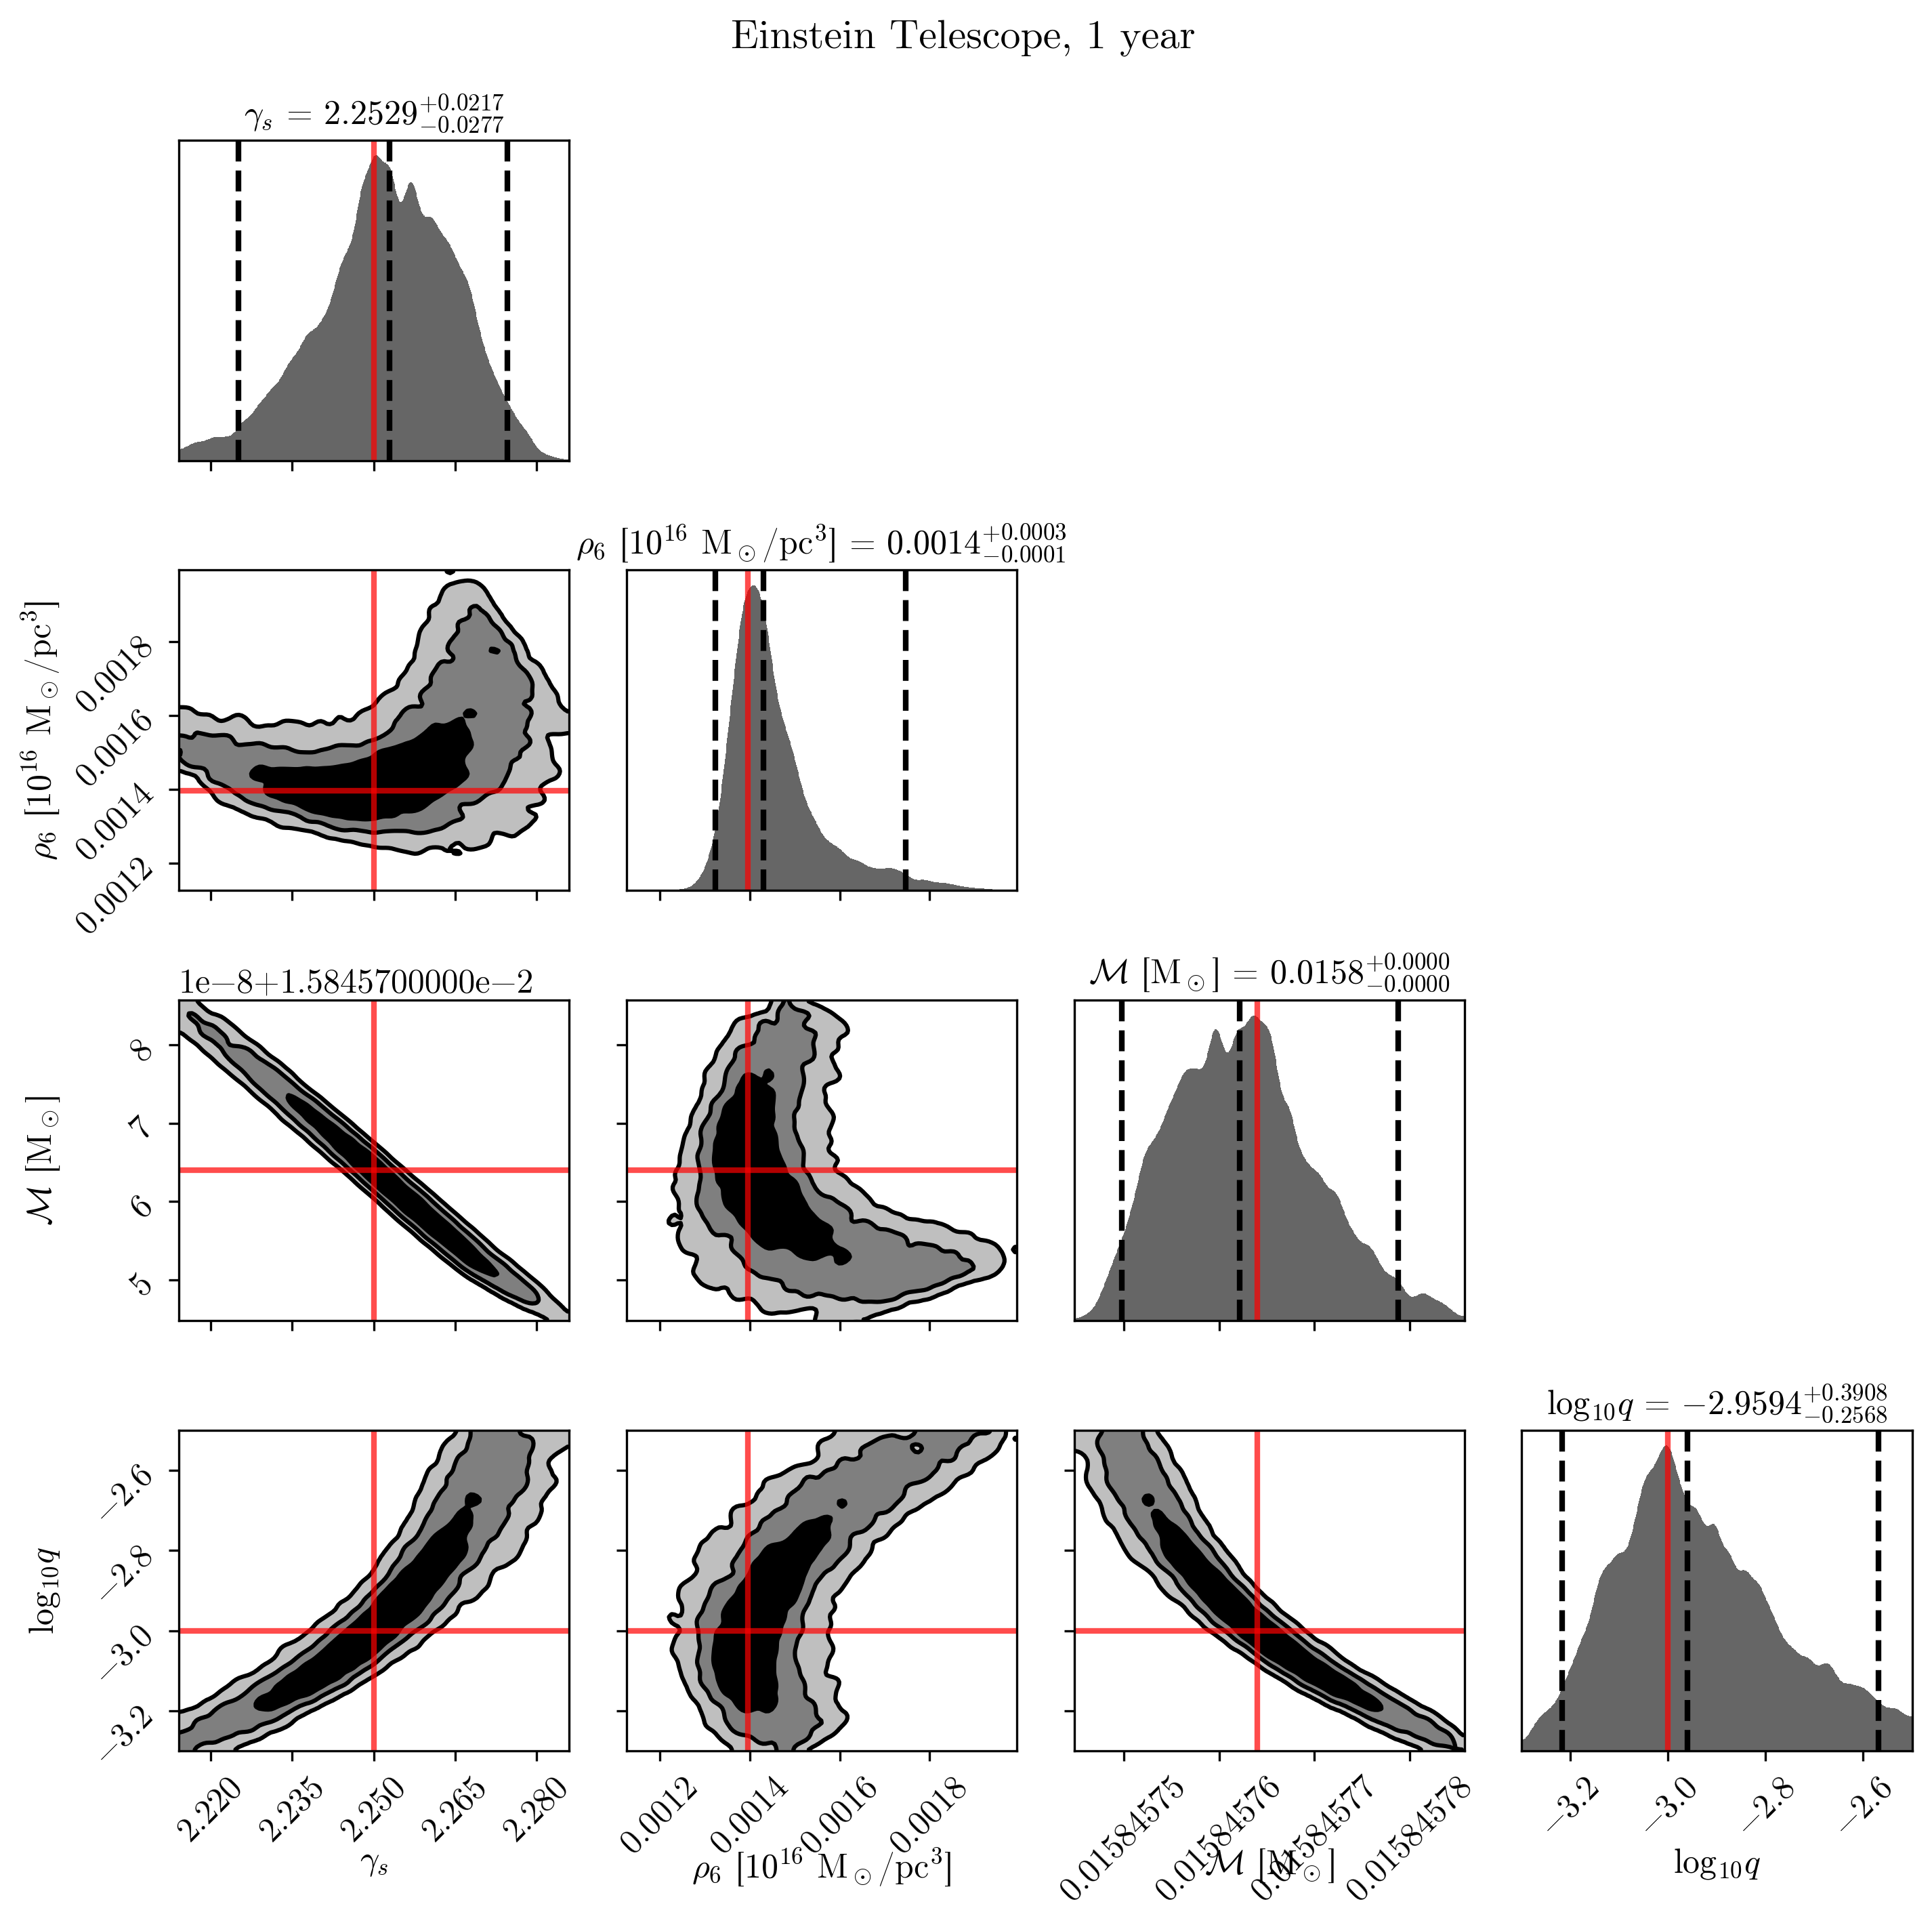

In [80]:
fig, axes = dyplot.cornerplot(
    results_et_1yr,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle("Einstein Telescope, 1 year")
fig.tight_layout()
# fig.savefig(f"figures/ns-ce.pdf")